In [ ]:
#| include: false
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import fastbook
fastbook.setup_book()

from fastbook import *

Application specific imports

In [ ]:
from fastai.text.all import *
from fastai.distributed import *

from xcube.text.learner import text_classifier_learner
from xcube.metrics import PrecisionK

#### Setting the base path as the path of the repository

In [ ]:
path = Path.cwd()
path_data = path/'data'
path_model = path/'models'

path_model.mkdir(exist_ok=True)
path_data.mkdir(exist_ok=True)

file_prefix = 'wiki-500k'

data = path_data/(file_prefix+'.csv')
dls_lm_path = path_model/f"{file_prefix}_dls_lm.pkl"
dls_lm_vocab_path = path_model/f"{file_prefix}_dls_lm_vocab.pkl"
dls_clas_path = path_model/f"{file_prefix}_dls_clas.pkl"

print(f"{ path = },\n {path_data = },\n {path_model = },\n {file_prefix = },\n {data = },\n {dls_lm_path =},\n {dls_lm_vocab_path = },\n {dls_clas_path = }.")

 path = Path('/home/deb/xcube/nbs/examples/wiki-500k'),
 path_data = Path('/home/deb/xcube/nbs/examples/wiki-500k/data'),
 path_model = Path('/home/deb/xcube/nbs/examples/wiki-500k/models'),
 file_prefix = 'wiki-500k',
 data = Path('/home/deb/xcube/nbs/examples/wiki-500k/data/wiki-500k.csv'),
 dls_lm_path =Path('/home/deb/xcube/nbs/examples/wiki-500k/models/wiki-500k_dls_lm.pkl'),
 dls_lm_vocab_path = Path('/home/deb/xcube/nbs/examples/wiki-500k/models/wiki-500k_dls_lm_vocab.pkl'),
 dls_clas_path = Path('/home/deb/xcube/nbs/examples/wiki-500k/models/wiki-500k_dls_clas.pkl').


## `DataLoaders` for the Language Model

To be able to use Transfer Learning, first we need to fine-tune our Language Model (which we pretrained on Wikipedia) on the corpus of Wiki-500k (the one we downloaded). Here we will build the `DataLoaders` object using fastai's `DataBlock` API:

In [ ]:
# !head -n 1 {data}

In [ ]:
df = pd.read_csv(data, header=0, names=['text', 'labels', 'is_valid'], dtype={'text': str, 'labels': str})

In [ ]:
len(df)

2549302

In [ ]:
df[['text', 'labels']] = df[['text', 'labels']].astype(str)

Let's take a look at the data:

In [ ]:
df.head(3)

,text,labels,is_valid
0,"Anarchism is a political philosophy that advocates self-governed societies based on voluntary institutions. These are often described as stateless societies, although several authors have defined them more specifically as institutions based on non-hierarchical or free associations. Anarchism holds the state to be undesirable, unnecessary and harmful.While opposition to the state is central, anarchism specifically entails opposing authority or hierarchical organisation in the conduct of all human relations. Anarchism is usually considered a far-left ideology and much of anarchist economics ...","81199,83757,83805,193030,368811,368937,423960",False
1,"Albedo () (Latin: albedo, meaning ""whiteness"") is the measure of the diffuse reflection of solar radiation out of the total solar radiation received by an astronomical body (e.g. a planet like Earth). It is dimensionless and measured on a scale from 0 (corresponding to a black body that absorbs all incident radiation) to 1 (corresponding to a body that reflects all incident radiation). Surface albedo is defined as the ratio of irradiance reflected to the irradiance received by a surface. The proportion reflected is not only determined by properties of the surface itself, but also by the sp...","144177,144212,182348,386554,387310,410664",False
2,"In Greek mythology, Achilles or Achilleus ( ə-KIL-eez; Greek: Ἀχιλλεύς, Achilleus [a.kʰil.le͜ús]) was a Greek hero of the Trojan War and the central character and greatest warrior of Homer's Iliad. His mother was the immortal Nereid Thetis, and his father, the mortal Peleus, was the king of the Myrmidons. Achilles' most notable feat during the Trojan War was the slaying of the Trojan hero Hector outside the gates of Troy. Although the death of Achilles is not presented in the Iliad, other sources concur that he was killed near the end of the Trojan War by Paris, who shot him in the heel w...","134702,167207,225935,362613,457078",False


We will now create the `DataLoaders` using `DataBlock` API:

In [ ]:
dls_lm = DataBlock(
    blocks   = TextBlock.from_df('text', is_lm=True, n_workers=4),
    get_x    = ColReader('text'),
    splitter = RandomSplitter(0.1)
).dataloaders(df, bs=384, seq_len=80)

Let's take a look at the batches:

In [ ]:
dls_lm.show_batch(max_n=2)

/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:475: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:475: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:475: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:475: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))


,text,text_
0,"xxbos xxmaj neck xxmaj road ( formerly xxmaj gravesend xxmaj neck xxmaj road ) is a local station on the xxup bmt xxmaj brighton xxmaj line of the xxmaj new xxmaj york xxmaj city xxmaj subway . xxmaj served by the q train at all times , it is located at xxmaj gravesend xxmaj neck xxmaj road between xxmaj east 15th and xxmaj east 16th xxmaj streets in xxmaj xxunk , xxmaj brooklyn . = = xxmaj station layout =","xxmaj neck xxmaj road ( formerly xxmaj gravesend xxmaj neck xxmaj road ) is a local station on the xxup bmt xxmaj brighton xxmaj line of the xxmaj new xxmaj york xxmaj city xxmaj subway . xxmaj served by the q train at all times , it is located at xxmaj gravesend xxmaj neck xxmaj road between xxmaj east 15th and xxmaj east 16th xxmaj streets in xxmaj xxunk , xxmaj brooklyn . = = xxmaj station layout = ="
1,"rapes arranged as he believed him to be writing a piece on prison corruption for xxmaj the xxmaj washington xxmaj post . xxmaj that night , xxmaj donaldson was lured into a cell by a prisoner who claimed that he and his friends wanted to ' discuss pacifism ' with him in their cells . xxmaj he was then xxunk and orally raped dozens of times by an estimated 45 male inmates . xxmaj he suffered additional abuse a second","arranged as he believed him to be writing a piece on prison corruption for xxmaj the xxmaj washington xxmaj post . xxmaj that night , xxmaj donaldson was lured into a cell by a prisoner who claimed that he and his friends wanted to ' discuss pacifism ' with him in their cells . xxmaj he was then xxunk and orally raped dozens of times by an estimated 45 male inmates . xxmaj he suffered additional abuse a second night"


The length of our vocabulary is:

In [ ]:
len(dls_lm.vocab)

60008

Let's take a look at some words of the vocab:

In [ ]:
print(coll_repr(L(dls_lm.vocab), 30))

(#60008) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the',',','.','of','=','and','in','a','to','-','(',')','"','was','is','for','on','as','3','by','with'...]


Creating the `DataLaoders` takes some time, so smash that *save* button (also a good idea to save the `dls_lm.vocab` for later use):

In [ ]:
torch.save(dls_lm, path_model/'wiki-500k_dls_lm.pkl')
torch.save(dls_lm.vocab, path_model/'wiki-500k_dls_lm_vocab.pkl')

To load back the `dls_lm` later on:

In [ ]:
dls_lm = torch.load(path_model/'wiki-500k_dls_lm.pkl')

## `Learner` for the Language Model Fine-Tuning:

In [ ]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3,
    metrics=[accuracy, Perplexity()]).to_fp16()

Let's compute the learning rate using the `lr_find`:

(0.017378008365631102,
 0.03981071710586548,
 0.00363078061491251,
 0.015848932787775993)

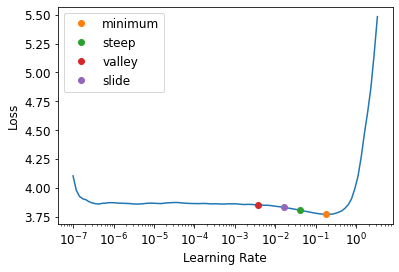

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide

In [ ]:
learn.fit_one_cycle(1, lr_min)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.488356,3.449270,0.399913,31.477398,04:24


It takes quite a while to train each epoch, so we'll be saving the intermediate model results during the training process:

In [ ]:
learn.save(path_model/'wiki-500k_lm')

Path('/home/deb/xcube/nbs/examples/mimic/models/caml_lm_recent.pth')

Let's now load back the `Learner`

In [ ]:
learn = learn.load(path_model/'wiki-500k_lm')

Let's validate the `Learner` to make sure we loaded the correct version:

In [ ]:
learn.validate()

Since we have completed the initial training, we will now continue fine-tuning the model after unfreezing:

In [ ]:
learn.unfreeze()

and run `lr_find` again, because we now have more layers to train, and the last layers weight have already been trained for one epoch:

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide

Let's now traing with a suitable learning rate:

In [ ]:
learn.fit_one_cycle(10, lr_max=2e-3, cbs=SaveModelCallback(fname=path_model/'wiki-500k_lm'))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.700497,2.601790,0.498114,13.487859,21:50
1,2.532751,2.447730,0.516926,11.562066,21:53
2,2.438119,2.364874,0.527396,10.642694,21:45
3,2.373062,2.317114,0.533622,10.146353,21:37
4,2.315276,2.284130,0.538038,9.817142,21:30
5,2.294005,2.259134,0.541297,9.574790,21:33
6,2.244216,2.240372,0.544038,9.396826,21:33
7,2.236868,2.227880,0.546116,9.280175,21:30
8,2.209610,2.221307,0.547150,9.219376,21:31
9,2.166203,2.220918,0.547269,9.215789,21:37


Better model found at epoch 0 with valid_loss value: 2.601789951324463.
Better model found at epoch 1 with valid_loss value: 2.4477295875549316.
Better model found at epoch 2 with valid_loss value: 2.3648736476898193.
Better model found at epoch 3 with valid_loss value: 2.3171143531799316.
Better model found at epoch 4 with valid_loss value: 2.284130096435547.
Better model found at epoch 5 with valid_loss value: 2.2591335773468018.
Better model found at epoch 6 with valid_loss value: 2.2403719425201416.
Better model found at epoch 7 with valid_loss value: 2.2278804779052734.
Better model found at epoch 8 with valid_loss value: 2.2213072776794434.
Better model found at epoch 9 with valid_loss value: 2.2209181785583496.


Note: Make sure if you have trained the most language model `Learner` for more epochs (then you need to save that version)

### Saving the encoder of the Language Model

**Crucial:** Once we have trained our LM we will save all of our model except the final layer that converts activation to probabilities of picking each token in our vocabulary. The model not including the final layer has a sexy name - *encoder*. We will save it using `save_encoder` method of the `Learner`:

In [ ]:
learn.save_encoder(path_model/'wiki-500k_lm_finetuned')

This completes the second stage of the text classification process - fine-tuning the Language Model pretrained on Wikipedia corpus. We will now use it to fine-tune a text multi-label text classifier.